In [1]:
import numpy as mp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import socket
import pickle
import random
from Pyfhel import Pyfhel
from Crypto.Cipher import AES #pip install pycryptodome
from base64 import b64encode, b64decode
import os
from random import seed
from random import randint

In [2]:
class Dec_Tree():
    
    def __init__(self,file_link,delimiter,save_filename):
        
        self.data = pd.read_csv(file_link,delimiter)
        for i in range (len(self.data.columns)-1):
            self.data[self.data.columns[i]] = round(self.data[self.data.columns[i]])
        self.x = self.data[self.data.columns[0:-1]]
        self.y = self.data[self.data.columns[-1]]
        self.encoding()
        self.feature_names = self.data.columns[:-1]
        self.target_names = self.data.columns[-1]
        self.savefile = save_filename
        self.save = 0
                
    def encoding(self):
        self.y = self.y.astype('category')
        self.y = self.y.cat.codes
        
    def print_data(self):
        print (self.x)
        print (self.y)
        
    def train_test(self):
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(self.x,self.y,test_size=0.15,random_state=20)
        
    def run_model(self):
        self.train_test()
        self.dec_tree = DecisionTreeClassifier(random_state=0,max_depth=6)
        self.dec_tree.fit(self.train_x,self.train_y)
        self.thresholds = self.dec_tree.tree_.threshold
        self.features_split_tree = self.dec_tree.tree_.feature
    
    def visualize(self):
        plt.figure(figsize=(25,10))
        self.visualize = plot_tree(self.dec_tree)
        print (self.thresholds)
        print (self.features_split_tree)
        
    def save_model(self):
        pickle.dump(self.dec_tree, open(self.savefile, 'wb'))
        self.save = 1
    
    def load_model(self):
        if(self.save):
            self.dec_model = pickle.load(open(self.savefile, 'rb'))
            
    def get_thresholds(self):
        return self.thresholds
    
    def get_features(self):
        return self.features_split_tree
            
    
        
        
        

In [3]:
class User(Dec_Tree):
    
    def Pyfhel_Object(self):
        self.pyf = Pyfhel()
        
    def public_parameters(self,public):
        self.pp = self.pyf.contextGen(p=65537, m=1024, flagBatching=True) 
        
    def key_generation(self):
        self.pyf.keyGen()
        
    def aes_tree(self,block_size):
        self.block_size = block_size
        self.aes_secret_key = os.urandom(self.block_size)  #generate aes object
        self.aes_cipher = AES.new(self.aes_secret_key, AES.MODE_CBC, iv=b'0123456789abcdef')  # create a cipher object using the random secret
        
    def encrypt_tree(self):
        print ("Encrypting Tree Model and features")
        # -2 value on list menas it is leaf node. We update thresholds for that to 0.
        self.encrypted_thresholds = [[]]
        get = self.get_thresholds()
        for i in range(len(get)):
            '''if(get[i]==-2):
                get[i] = 0'''
            
            get[i] = round(get[i])
            #print(get[i])
            k = get[i]
            binary_list = []
            while(k):
                temp = self.pyf.encryptInt(k%2)
                #print (temp)
                binary_list.append(temp)
                k = k/2
                 
            self.encrypted_thresholds.append(binary_list)
            print ("Threshold number " + str(i+1) + " encrypted")
         
        print ("Encryption of Model Data Completed")
        return self.encrypted_thresholds
        
        

      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0      1            5.0           4.0            1.0           0.0
1      2            5.0           3.0            1.0           0.0
2      3            5.0           3.0            1.0           0.0
3      4            5.0           3.0            2.0           0.0
4      5            5.0           4.0            1.0           0.0
..   ...            ...           ...            ...           ...
145  146            7.0           3.0            5.0           2.0
146  147            6.0           2.0            5.0           2.0
147  148            6.0           3.0            5.0           2.0
148  149            6.0           3.0            5.0           2.0
149  150            6.0           3.0            5.0           2.0

[150 rows x 5 columns]
0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Length: 150, dtype: int8
[ 51.   -2.  100.5  -2.   -2. ]
[ 0 -2  0 -2 -2]

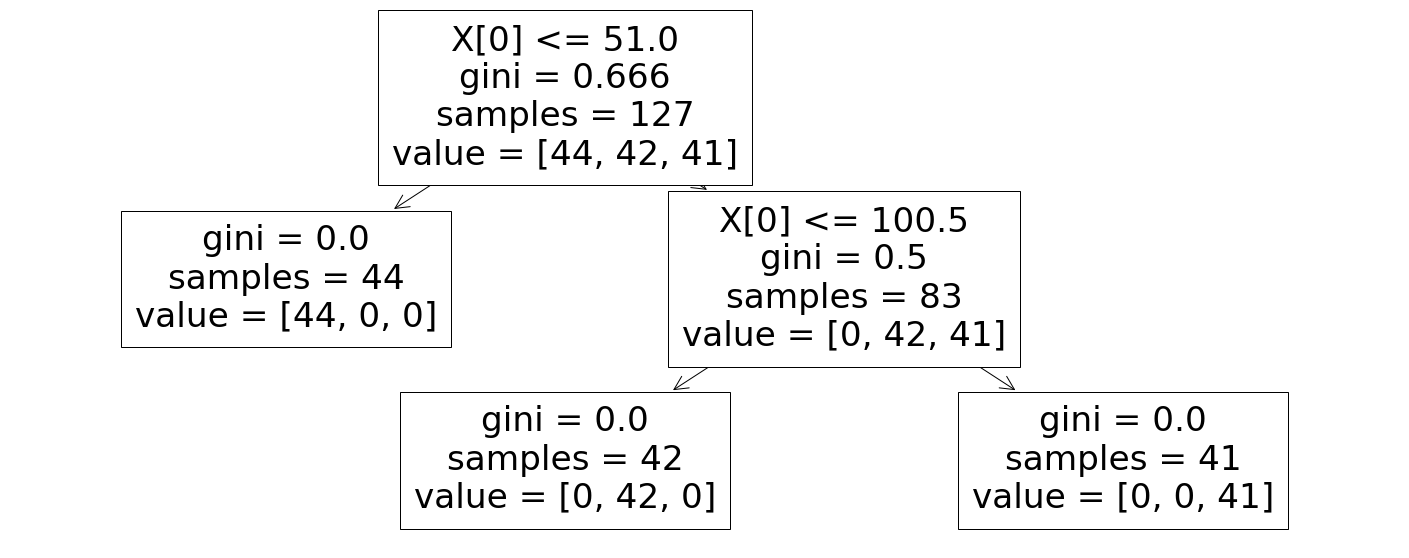

In [4]:
if __name__ == "__main__":
    r = User('Iris.csv',',','Iris_data.sav')
    r.print_data()
    r.run_model()
    r.visualize()